<a href="https://colab.research.google.com/github/Pranav003/Machine-Learning-project-1/blob/master/transformers_encoder_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing the Transformer Encoder from Scratch

In [ ]:
pip install transformers


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Layer, Dense, ReLU
import torch.nn as nn

creating the class FeedForward that inherits from the Layer base class in Keras and initialize the dense layers and the ReLU activation:

In [4]:
class FeedForward(Layer):
    def __init__(self, d_ff, d_model, **kwargs):
        super(FeedForward, self).__init__(**kwargs)
        self.fully_connected1 = Dense(d_ff)  # First fully connected layer
        self.fully_connected2 = Dense(d_model)  # Second fully connected layer
        self.activation = ReLU()  # ReLU activation layer

In [5]:
pip install attention

In [6]:
pip show transformers

Name: transformers
Version: 4.28.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, tokenizers, tqdm
Required-by: 


In [11]:
class MultiHeadAttention(nn.Module):
    """
    multi-head attention is used in both the encoder and decoder layers to help
    the model better capture long-range dependencies and relationships between input
    and output sequences."""
    def __init__(self, d_model, n_head):
        super(MultiHeadAttention, self).__init__()
        self.n_head = n_head
        self.attention = ScaleDotProductAttention()
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_concat = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        # 1. dot product with weight matrices
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # 2. split tensor by number of heads
        q, k, v = self.split(q), self.split(k), self.split(v)

        # 3. do scale dot product to compute similarity
        out, attention = self.attention(q, k, v, mask=mask)
        
        # 4. concat and pass to linear layer
        out = self.concat(out)
        out = self.w_concat(out)

        # 5. visualize attention map
        # TODO : we should implement visualization

        return out

    def split(self, tensor):
        """
        split tensor by number of head

        :param tensor: [batch_size, length, d_model]
        :return: [batch_size, head, length, d_tensor]
        """
        batch_size, length, d_model = tensor.size()

        d_tensor = d_model // self.n_head
        tensor = tensor.view(batch_size, length, self.n_head, d_tensor).transpose(1, 2)
        # it is similar with group convolution (split by number of heads)

        return tensor

    def concat(self, tensor):
        """
        inverse function of self.split(tensor : torch.Tensor)

        :param tensor: [batch_size, head, length, d_tensor]
        :return: [batch_size, length, d_model]
        """
        batch_size, head, length, d_tensor = tensor.size()
        d_model = head * d_tensor

        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, length, d_model)
        return tensor

In [12]:
class PositionalEncoding(nn.Module):
    """
    compute sinusoid encoding.
    """
    def __init__(self, d_model, max_len, device):
        """
        constructor of sinusoid encoding class

        :param d_model: dimension of model
        :param max_len: max sequence length
        :param device: hardware device setting
        """
        super(PositionalEncoding, self).__init__()

        # same size with input matrix (for adding with input matrix)
        self.encoding = nn.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False  # we don't need to compute gradient

        pos = nn.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1)
        # 1D => 2D unsqueeze to represent word's position

        _2i = nn.arange(0, d_model, step=2, device=device).float()
        # 'i' means index of d_model (e.g. embedding size = 50, 'i' = [0,50])
        # "step=2" means 'i' multiplied with two (same with 2 * i)

        self.encoding[:, 0::2] = nn.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = nn.cos(pos / (10000 ** (_2i / d_model)))
        # compute positional encoding to consider positional information of words

    def forward(self, x):
        # self.encoding
        # [max_len = 512, d_model = 512]

        batch_size, seq_len = x.size()
        # [batch_size = 128, seq_len = 30]

        return self.encoding[:seq_len, :]
        # [seq_len = 30, d_model = 512]
        # it will add with tok_emb : [128, 30, 512]       

In [13]:
class ScaleDotProductAttention(nn.Module):
    """
    compute scale dot product attention

    Query : given sentence that we focused on (decoder)
    Key : every sentence to check relationship with Qeury(encoder)
    Value : every sentence same with Key (encoder)
    """
'''ScaleDotProductAttention mechanism computes the attention weights between each 
position in the input sequence and all other positions in the sequence. This allows the
 model to attend to different parts of the input sequence simultaneously,
  enabling it to capture complex patterns and dependencies.'''
    def __init__(self):
        super(ScaleDotProductAttention, self).__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, mask=None, e=1e-12):
        # input is 4 dimension tensor
        # [batch_size, head, length, d_tensor]
        batch_size, head, length, d_tensor = k.size()

        # 1. dot product Query with Key^T to compute similarity
        k_t = k.transpose(2, 3)  # transpose
        score = (q @ k_t) / np.sqrt(d_tensor)  # scaled dot product

        # 2. apply masking (opt)
        if mask is not None:
            score = score.masked_fill(mask == 0, -10000)

        # 3. pass them softmax to make [0, 1] range
        score = self.softmax(score)

        # 4. multiply with Value
        v = score @ v

        return v, score


IndentationError: ignored

In [14]:
class PositionwiseFeedForward(nn.Module):
    '''The PositionwiseFeedForward layer consists of two linear 
    transformations with a ReLU activation function in between.'''
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [15]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, ffn_hidden, n_head, drop_prob):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        self.norm1 = nn.LayerNorm(d_model=d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = nn.LayerNorm(d_model=d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x, src_mask):
        # 1. compute self attention
        _x = x
        x = self.attention(q=x, k=x, v=x, mask=src_mask)
        
        # 2. add and norm
        x = self.dropout1(x)
        x = self.norm1(x + _x)
        
        # 3. positionwise feed forward network
        _x = x
        x = self.ffn(x)
      
        # 4. add and norm
        x = self.dropout2(x)
        x = self.norm2(x + _x)
        return x

    def __init__(self, enc_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device):
        super().__init__()
        self.emb = nn.TransformerEmbedding(d_model=d_model,
                                        max_len=max_len,
                                        vocab_size=enc_voc_size,
                                        drop_prob=drop_prob,
                                        device=device)

        self.layers = nn.ModuleList([EncoderLayer(d_model=d_model,
                                                  ffn_hidden=ffn_hidden,
                                                  n_head=n_head,
                                                  drop_prob=drop_prob)
                                     for _ in range(n_layers)])

    def forward(self, x, src_mask):
        x = self.emb(x)

        for layer in self.layers:
            x = layer(x, src_mask)

        return x

In [16]:
class DecoderLayer(nn.Module):

    def __init__(self, d_model, ffn_hidden, n_head, drop_prob):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        self.norm1 = nn.LayerNorm(d_model=d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.enc_dec_attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        self.norm2 = nn.LayerNorm(d_model=d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm3 = nn.LayerNorm(d_model=d_model)
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self, dec, enc, trg_mask, src_mask):    
        # 1. compute self attention
        _x = dec
        x = self.self_attention(q=dec, k=dec, v=dec, mask=trg_mask)
        
        # 2. add and norm
        x = self.dropout1(x)
        x = self.norm1(x + _x)

        if enc is not None:
            # 3. compute encoder - decoder attention
            _x = x
            x = self.enc_dec_attention(q=x, k=enc, v=enc, mask=src_mask)
            
            # 4. add and norm
            x = self.dropout2(x)
            x = self.norm2(x + _x)

        # 5. positionwise feed forward network
        _x = x
        x = self.ffn(x)
        
        # 6. add and norm
        x = self.dropout3(x)
        x = self.norm3(x + _x)
        return x
    def __init__(self, dec_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device):
        super().__init__()
        self.emb = nn.TransformerEmbedding(d_model=d_model,
                                        drop_prob=drop_prob,
                                        max_len=max_len,
                                        vocab_size=dec_voc_size,
                                        device=device)

        self.layers = nn.ModuleList([DecoderLayer(d_model=d_model,
                                                  ffn_hidden=ffn_hidden,
                                                  n_head=n_head,
                                                  drop_prob=drop_prob)
                                     for _ in range(n_layers)])

        self.linear = nn.Linear(d_model, dec_voc_size)

    def forward(self, trg, src, trg_mask, src_mask):
        trg = self.emb(trg)

        for layer in self.layers:
            trg = layer(trg, src, trg_mask, src_mask)

        # pass to LM head
        output = self.linear(trg)
        return output

After training it on Multi30K dataset and following the settings and hyperparameters of original dataset , we found the training and validation result as given below

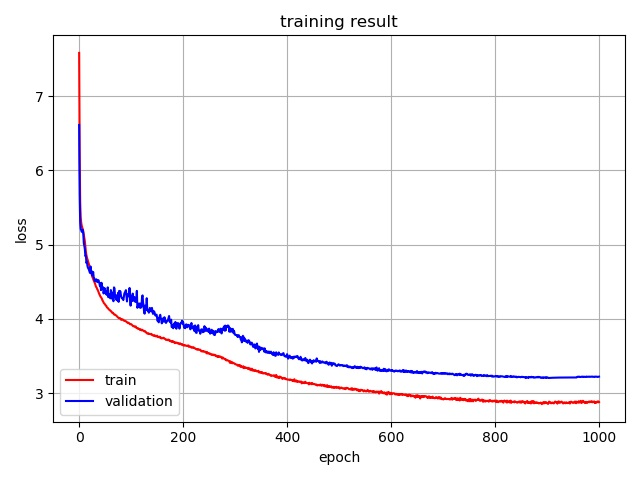

Minimum Training Loss = 2.852672759656864

Minimum Validation Loss = 3.2048025131225586